<a href="https://colab.research.google.com/github/AnujKrishnaPhuyal/DeepLearning-Practices/blob/main/custom_image_for_detection_algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import requests
import zipfile
from pathlib import Path
import torch
     

In [3]:
torch.cuda.is_available()

False

In [4]:

data_path = Path("data/")
image_path = data_path / "hybrid"
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    !cp -r "/content/drive/My Drive/hybrid" "/content/data/"

Did not find data/hybrid directory, creating one...


In [5]:
image_path

PosixPath('data/hybrid')

In [422]:
train_dir =image_path/"train"
test_dir = image_path/"test"

In [423]:
train_dir,test_dir

(PosixPath('data/hybrid/train'), PosixPath('data/hybrid/test'))

In [424]:
import os
from PIL import Image
from torchvision.transforms import ToTensor
from PIL import Image
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from torchvision import transforms

In [516]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_names = sorted([file for file in os.listdir(folder_path) if file.endswith('.jpg')])

    def __getitem__(self, index):
        file_name = self.file_names[index]
        image_path = os.path.join(self.folder_path, file_name)
        annotation_path = os.path.join(self.folder_path, file_name.replace('.jpg', '.xml'))

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image if necessary (e.g., resize, normalize, etc.)
        transform = transforms.Compose([
            # transforms.Resize((424, 424)),  # Resize the image to a specific size
            transforms.ToTensor()         # Convert the image to a PyTorch tensor
        ])
        image = transform(image)

        # Load and process the annotation
        annotation = self.load_annotation(annotation_path)

        # Convert annotation to the required format for Faster R-CNN
        boxes = torch.tensor(annotation["boxes"], dtype=torch.float32)
        labels = torch.tensor(annotation["labels"], dtype=torch.int64)

        # Return the preprocessed image and annotations
        return image, {
            "boxes": boxes,
            "labels": labels
        }

    def __len__(self):
        return len(self.file_names)

    def load_annotation(self, annotation_path):

      tree = ET.parse(annotation_path)
      root = tree.getroot()

      boxes = []
      labels = []

      label_to_idx = {"achyut": 0, "anuj": 1}  # Modify according to your class labels

      for obj in root.findall('object'):
          # Extract the bounding box coordinates
          bbox = obj.find('bndbox')
          xmin = float(bbox.find('xmin').text)
          ymin = float(bbox.find('ymin').text)
          xmax = float(bbox.find('xmax').text)
          ymax = float(bbox.find('ymax').text)
          boxes.append([xmin, ymin, xmax, ymax])

          # Extract the class label
          label = obj.find('name').text
          print(label)
          # labels.append([label])
          if label in label_to_idx:
              labels.append(label_to_idx[label])
          else:
              # Handle the case where the label is not present in label_to_idx
              labels.append(-1)  # You can assign a specific value to represent an unknown label

      return {"boxes": boxes, "labels": labels}
    



In [517]:
train_dataset = CustomDataset(train_dir)


In [518]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1)


In [519]:
import matplotlib.pyplot as plt


achyut
achyut
tensor([[0]]) tensor([[[131., 437., 513., 983.]]])


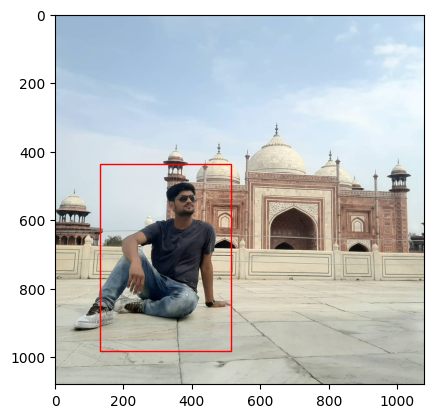

In [531]:
batch = next(iter(train_data_loader))
image= batch[0]
annotations = batch[1]
boxes_tensor =annotations["boxes"] 
print(annotations['labels'],annotations['boxes'])
for box in boxes_tensor:
    # Extract the coordinates of the bounding box
    xmin, ymin, xmax, ymax = boxes_tensor[0, 0].tolist()

    # Create a Rectangle patch
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red')

    # Add the patch to the current axis
    plt.gca().add_patch(rect)

# Display the image with bounding boxes
plt.imshow(image.squeeze(dim=0).permute(1,2,0))
# # Show the plot
